In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

def sine_gaussian_waveform(t, A, t0, tau, f0, phi0):
    gaussian_envelope = A * np.exp(-((t - t0)**2) / (2 * tau**2))
    sine_wave = np.cos(2 * np.pi * f0 * t + phi0)
    return gaussian_envelope * sine_wave

def add_glitches(signal, glitch_frequency, glitch_amplitude, glitch_duration, num_points):
    signal_with_glitches = signal.copy()
    for _ in range(int(glitch_frequency * num_points)):
        start_idx = np.random.randint(0, num_points - glitch_duration)
        end_idx = start_idx + glitch_duration
        glitch = np.random.uniform(-glitch_amplitude, glitch_amplitude, glitch_duration)
        signal_with_glitches[start_idx:end_idx] += glitch
    return signal_with_glitches

def add_noise(signal, noise_level_base, noise_variation, num_points):
    noise_level = abs(noise_level_base + np.random.uniform(-noise_variation, noise_variation))
    noise = np.random.uniform(-noise_level, noise_level, num_points)
    return signal + noise

def generate_waveform_data(num_samples, num_points, A_base, A_variation, t0_base, t0_variation, tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, time_length_base, time_length_variation, glitch_frequency=0.0, glitch_amplitude=0.0, glitch_duration=0, signal_present=True):
    data = [] 
    labels = []
    
    for _ in range(num_samples):
        A = A_base + np.random.uniform(-A_variation, A_variation)
        t0 = t0_base + np.random.uniform(-t0_variation, t0_variation)
        f0 = f0_base + np.random.uniform(-f0_variation, f0_variation)
        noise_level = abs(noise_level_base + np.random.uniform(-noise_variation, noise_variation))
        time_length = time_length_base + np.random.uniform(-time_length_variation, time_length_variation)
        
        t = np.linspace(0, time_length, num_points)

        if signal_present:
            waveform = sine_gaussian_waveform(t, A, t0, tau, f0, phi0)
            signal_with_noise = add_noise(waveform, noise_level_base, noise_variation, num_points)
            label = np.zeros_like(t)
            signal_start = np.argmin(np.abs(t - t0 + 3 * tau))
            signal_end = np.argmin(np.abs(t - t0 - 3 * tau))
            label[signal_start:signal_end] = 1
        else:
            signal_with_noise = np.random.uniform(-noise_level, noise_level, t.shape)
            label = np.zeros_like(t)

        if glitch_frequency > 0:
            signal_with_noise = add_glitches(signal_with_noise, glitch_frequency, glitch_amplitude, glitch_duration, num_points)
        
        sampled_amplitudes = signal_with_noise
        features = sampled_amplitudes
        data.append(features)
        labels.append(label)
    
    return np.array(data), np.array(labels)

def generate_coincidence_test_data(test_data, test_labels, noise_level_base, noise_variation, noise_variation_coincidence, glitch_frequency=0.0, glitch_amplitude=0.0, glitch_duration=0):
    coincident_data = []
    coincident_labels = []
    
    for i in range(test_data.shape[0]):
        signal = test_data[i]
        label = test_labels[i]
        
        # Slightly vary the noise level for each sample
        noise_level_variation = noise_variation_coincidence * np.random.uniform(-1, 1)
        signal_with_noise = add_noise(signal, noise_level_base, noise_variation + noise_level_variation, len(signal))
        
        # Add glitches
        if glitch_frequency > 0:
            signal_with_noise = add_glitches(signal_with_noise, glitch_frequency, glitch_amplitude, glitch_duration, len(signal))
        
        coincident_data.append(signal_with_noise)
        coincident_labels.append(label)
    
    return np.array(coincident_data), np.array(coincident_labels)


Training data shape: (4096, 100)
Test data shape: (4096, 100)
Coincidence test data shape: (4096, 100)
Training labels shape: (4096, 100)
Test labels shape: (4096, 100)
Coincidence test labels shape: (100, 4096)


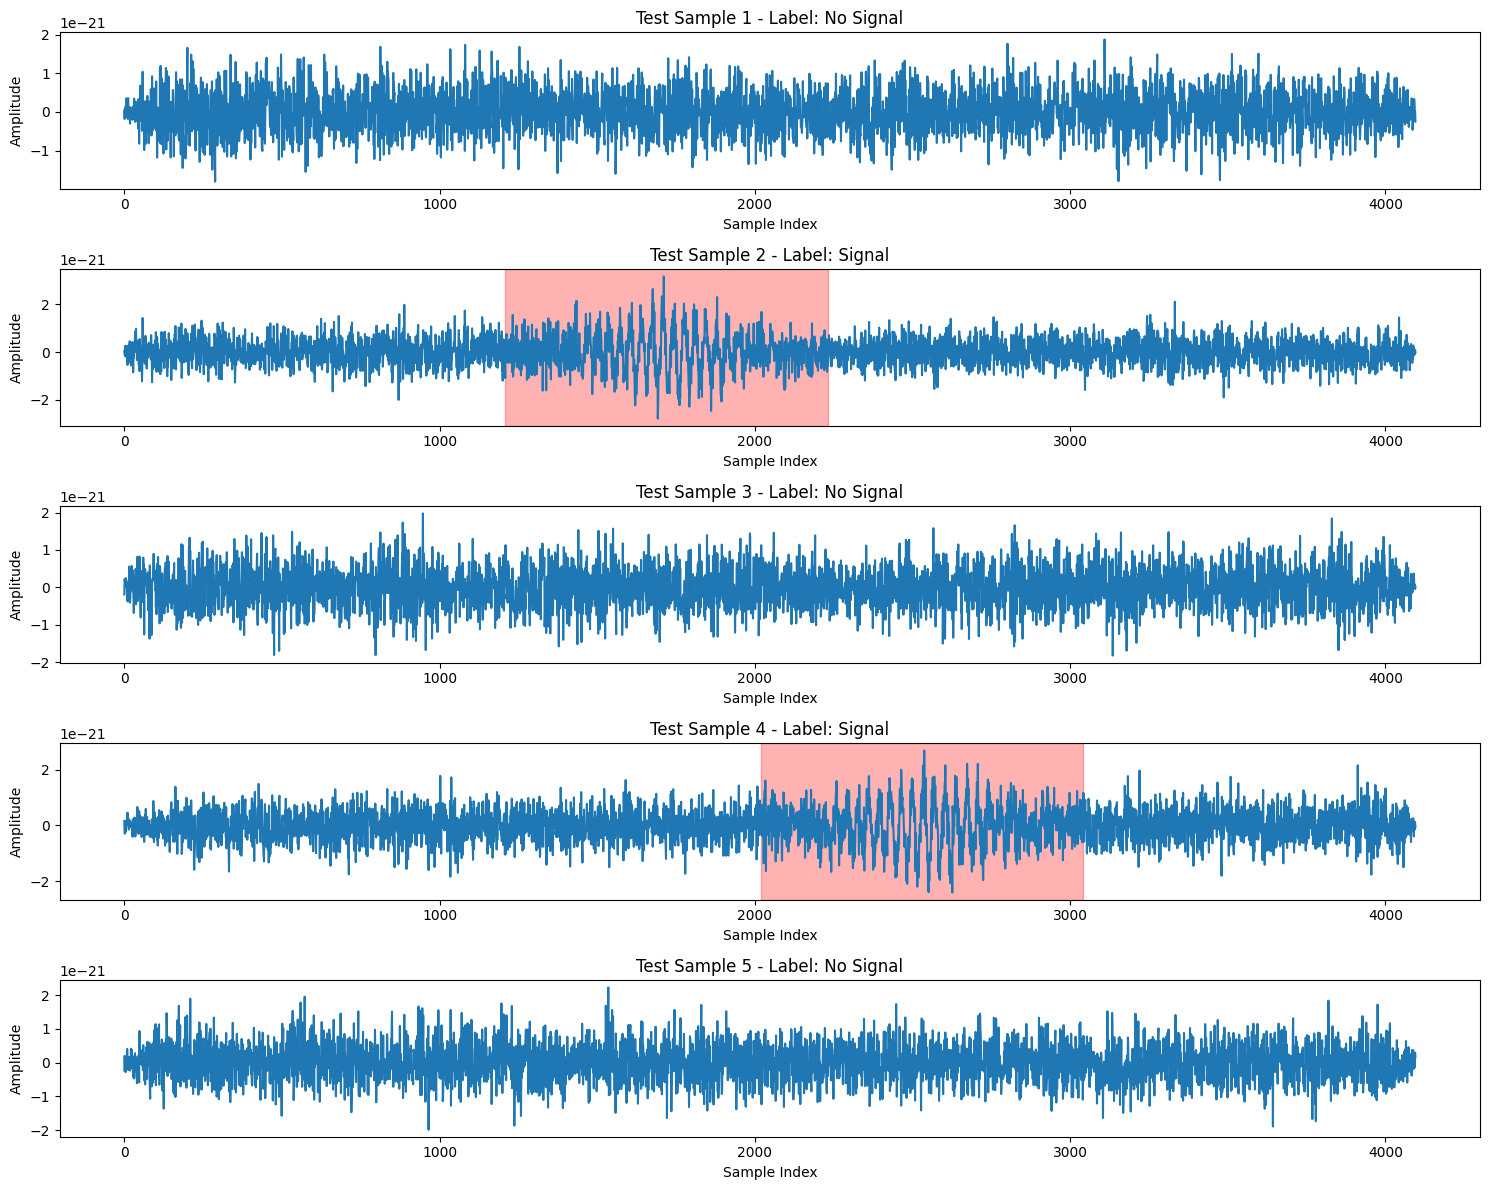

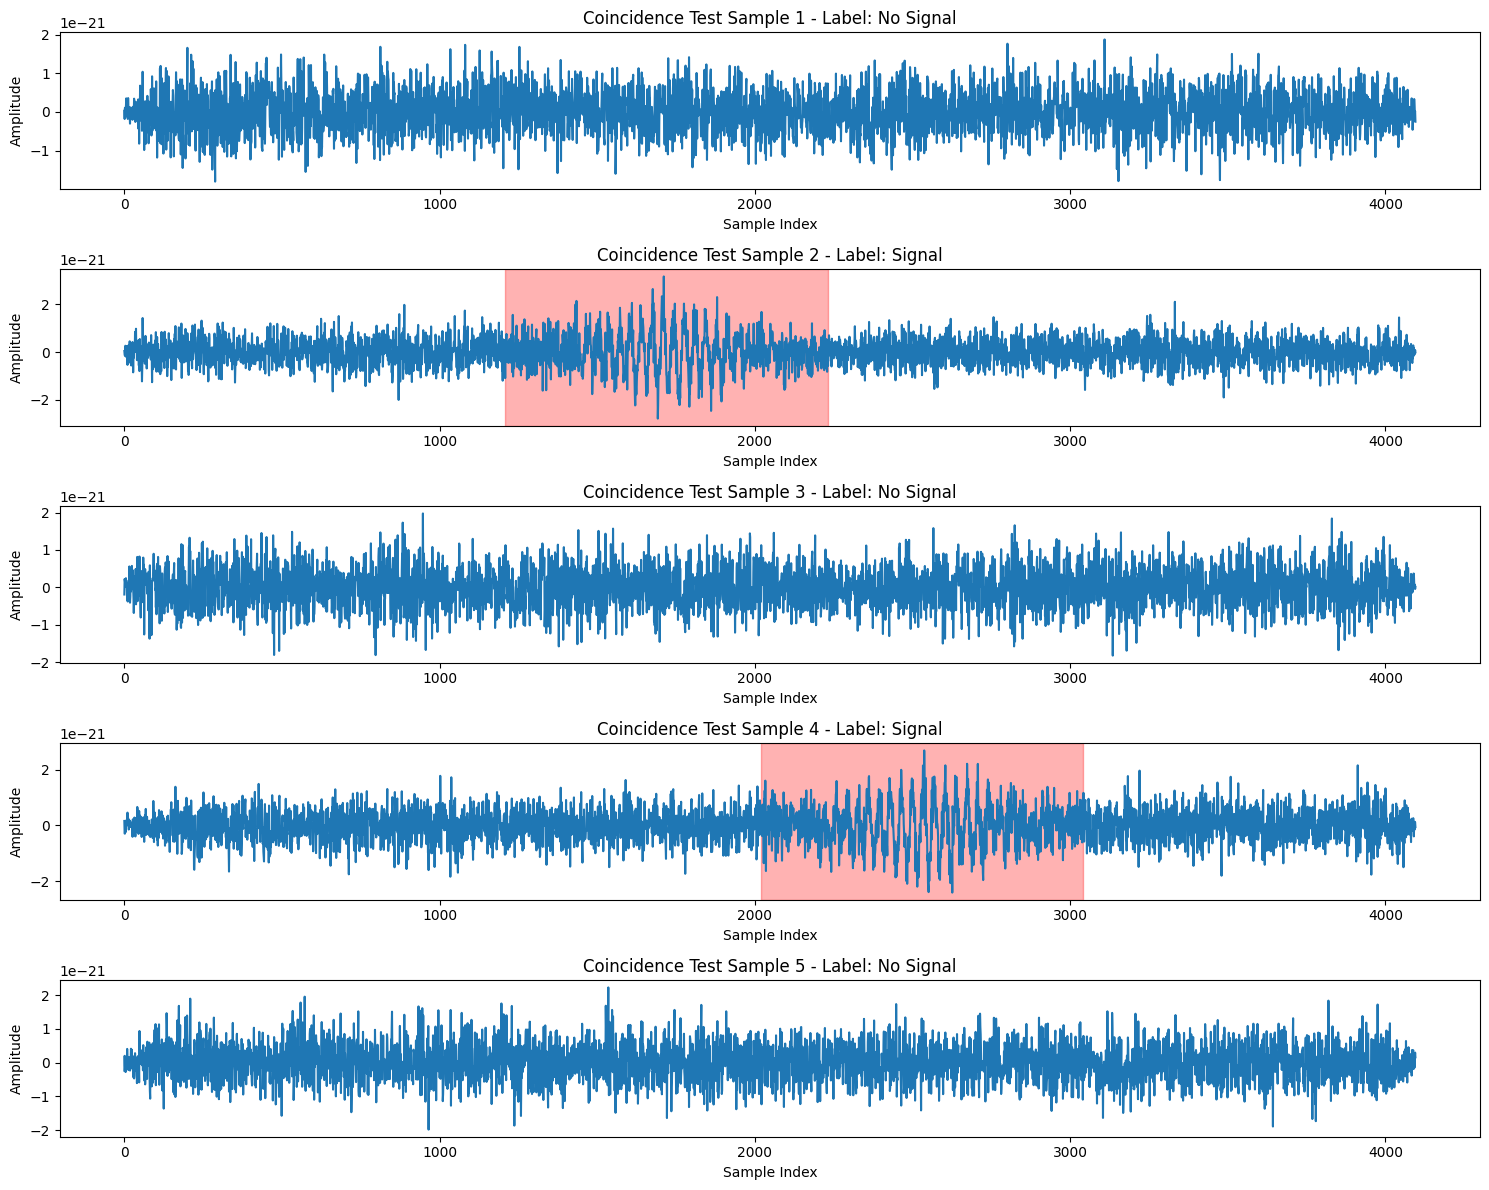

In [10]:
# Parameters for waveform generation
num_samples_per_class = 100
num_points = 4096

# Define base parameters for waveform generation
A_base = 15e-22
t0_base = 0.5
tau = 0.05
f0_base = 100
phi0 = 0.0

# Variations in parameters (only allowed in non-coincident data)
A_variation = 0e-22
t0_variation = 0.3
f0_variation = 10
noise_level_base = 3e-22
noise_variation = 0
time_length_base = 1.0
time_length_variation = 0.3

# Parameters for glitches
glitch_frequency = 0.2
glitch_amplitude = 2e-22
glitch_duration = 100

# Noise variation for coincident data
noise_variation_coincidence = 1e-23  # Slight variation in noise level for coincident data

# Generate data with and without signal
data_with_signal, labels_with_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
    signal_present=True
)

data_without_signal, labels_without_signal = generate_waveform_data(
    num_samples_per_class, num_points, A_base, A_variation, t0_base, t0_variation, 
    tau, f0_base, f0_variation, phi0, noise_level_base, noise_variation, 
    time_length_base, time_length_variation, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration,
    signal_present=False
)

# Combine data and labels
data = np.concatenate([data_with_signal, data_without_signal])
labels = np.concatenate([labels_with_signal, labels_without_signal])

# Shuffle the data and labels together
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]

# Scale each sample by the base amplitude used for the Gaussian sine wave
data = data / A_base

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.5, random_state=42)

# Generate coincident test data
coincidence_test_data, coincidence_test_labels = generate_coincidence_test_data(
    X_test, y_test, noise_level_base=noise_level_base, noise_variation=noise_variation,
    noise_variation_coincidence=noise_variation_coincidence, glitch_frequency=glitch_frequency, glitch_amplitude=glitch_amplitude, glitch_duration=glitch_duration
)

# Transpose the training, test, and coincident test data
X_train_transposed = X_train.T
X_test_transposed = X_test.T
coincidence_test_transposed = coincidence_test_data.T

# Save training data to CSV file
train_df = pd.DataFrame(X_train_transposed)
train_df.to_csv('train.csv', index=False)

# Save test data to CSV file
test_df = pd.DataFrame(X_test_transposed)
test_df.to_csv('test.csv', index=False)

# Save training labels to CSV file
labels_train_df = pd.DataFrame(y_train.T)
labels_train_df.to_csv('labels.csv', index=False)

# Save test labels to CSV file
labels_test_df = pd.DataFrame(y_test.T)
labels_test_df.T.to_csv('test_labels.csv', index=False)

# Save coincident test data and labels to CSV files
coincidence_test_df = pd.DataFrame(coincidence_test_transposed)
coincidence_test_df.to_csv('coincidence_test.csv', index=False)

coincidence_labels_df = pd.DataFrame(coincidence_test_labels)
coincidence_labels_df.to_csv('coincidence_test_labels.csv', index=False)

# Verify the shapes of saved data
print(f'Training data shape: {X_train_transposed.shape}')
print(f'Test data shape: {X_test_transposed.shape}')
print(f'Coincidence test data shape: {coincidence_test_transposed.shape}')
print(f'Training labels shape: {labels_train_df.shape}')
print(f'Test labels shape: {labels_test_df.shape}')
print(f'Coincidence test labels shape: {coincidence_labels_df.shape}')

# Plotting function for samples
def plot_samples(samples, labels, title_prefix, num_samples=5):
    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        plt.subplot(num_samples, 1, i + 1)
        sample = samples[i] * A_base
        plt.plot(sample)
        actual_label = "Signal" if np.any(labels[i] == 1) else "No Signal"
        plt.title(f'{title_prefix} Sample {i+1} - Label: {actual_label}')
        plt.xlabel('Sample Index')
        plt.ylabel('Amplitude')
        if actual_label == "Signal":
            signal_region = np.where(labels[i] == 1)[0]
            if len(signal_region) > 0:
                start_idx = signal_region[0]
                end_idx = signal_region[-1]
                plt.axvspan(start_idx, end_idx, color='red', alpha=0.3)
    plt.tight_layout()
    plt.show()

# Plot the first 5 samples from the test set
plot_samples(X_test, y_test, title_prefix='Test')

# Plot the first 5 samples from the coincident test set
plot_samples(coincidence_test_data, coincidence_test_labels, title_prefix='Coincidence Test')

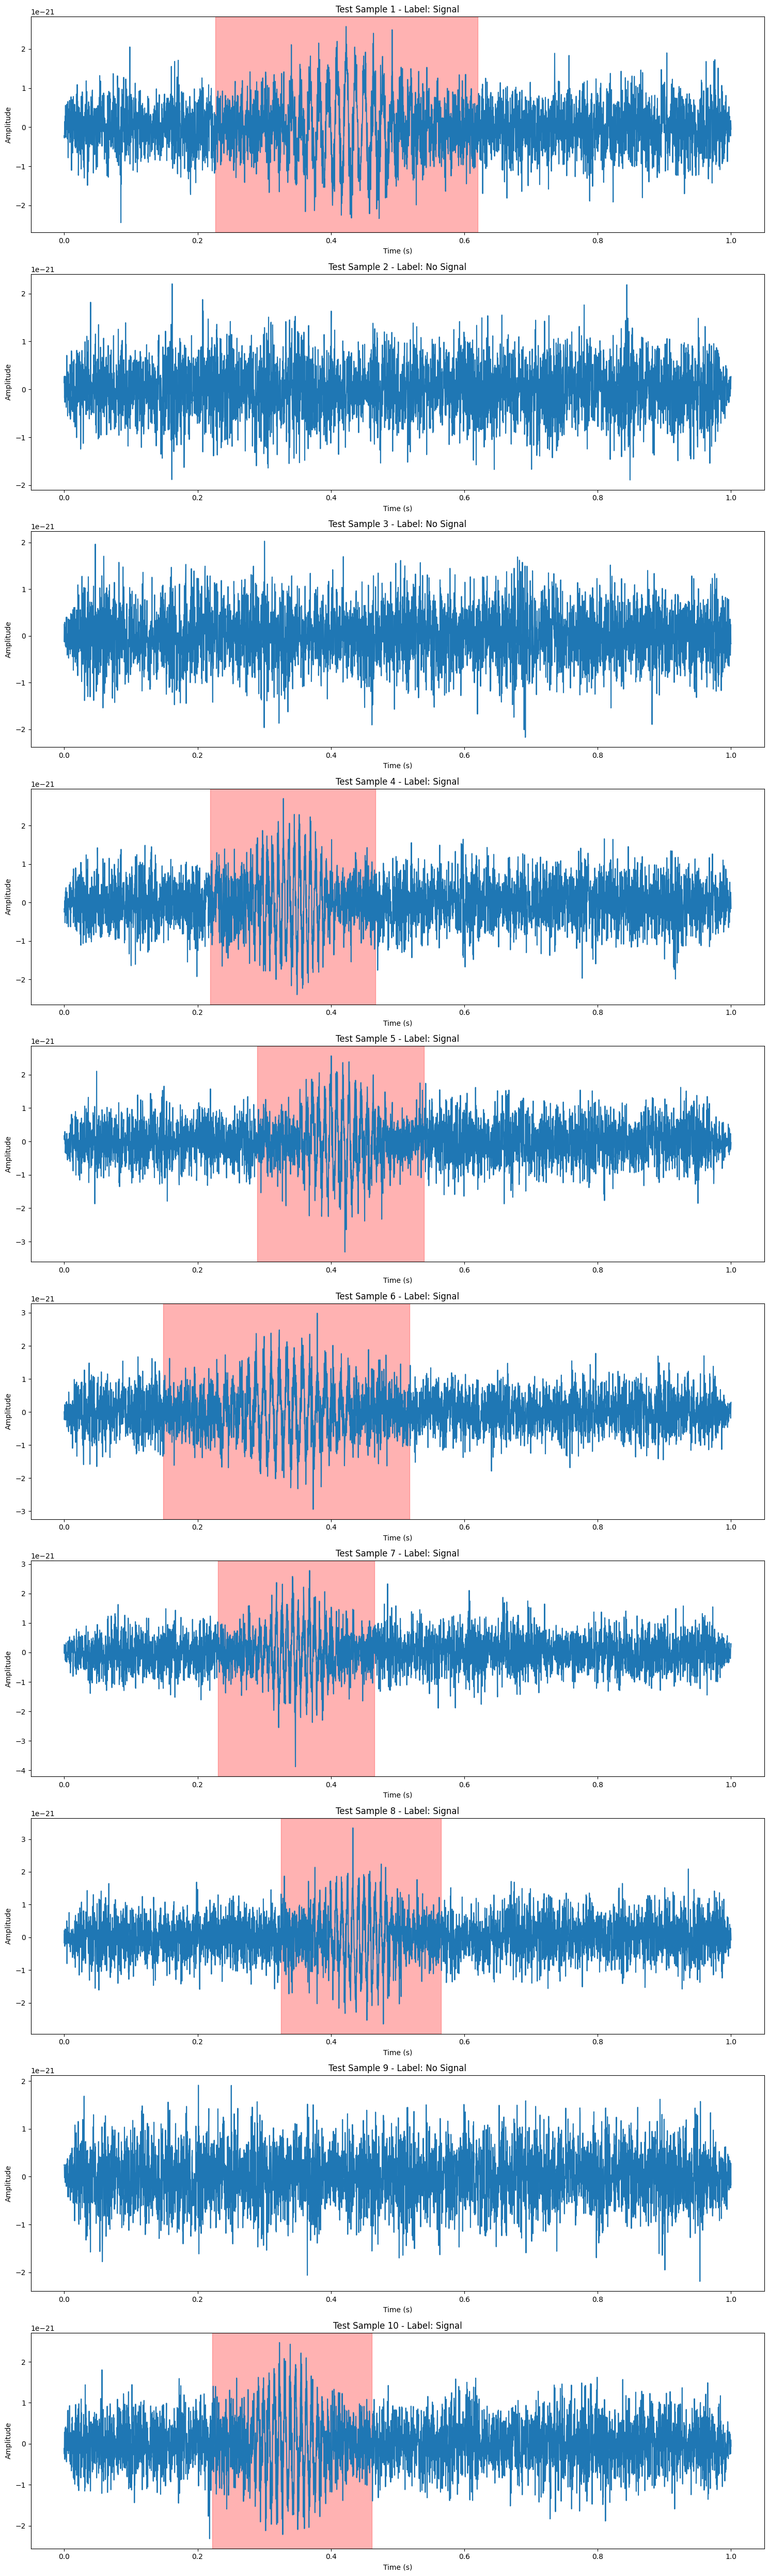

In [6]:
# Parameters for plotting
num_samples_to_plot = 10
num_points = 4096  # Number of time points in each sample
time_indices = np.linspace(0, 1, num_points)  # Time indices corresponding to the data

plt.figure(figsize=(15, 50))
for i in range(num_samples_to_plot):
    plt.subplot(num_samples_to_plot, 1, i + 1)
    sample = X_test[i] * A_base  # Scale back to the original amplitude
    plt.plot(time_indices, sample)  # Plot the sampled points
    actual_label = "Signal" if np.any(labels_test_df[i] == 1) else "No Signal"
    plt.title(f'Test Sample {i+1} - Label: {actual_label}')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    
    # Highlight the region where the signal is present
    if actual_label == "Signal":
        signal_region = np.where(labels_test_df[i] == 1)[0]
        if len(signal_region) > 0:
            start_idx = signal_region[0]
            end_idx = signal_region[-1]
            plt.axvspan(time_indices[start_idx], time_indices[end_idx], color='red', alpha=0.3)
            
plt.tight_layout()
plt.show()